Reference:https://www.kaggle.com/autuanliuyc/logistic-regression-with-tensorflow

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np # linear algebra
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os

### Step 1: Read the data

In [3]:
df=pd.read_csv('SAheart.data', sep=",")

In [4]:
df.shape

(462, 11)

In [5]:
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


### Step 2: A glance at the dataset

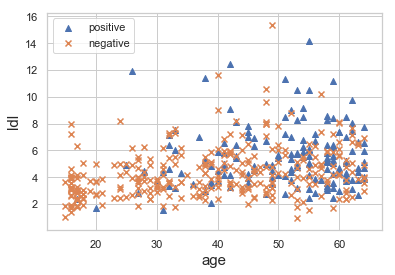

In [6]:
fig, ax = plt.subplots()
ax.scatter(df[df["chd"]==1]["age"],df[df["chd"]==1]["ldl"],marker='^',label='positive')
ax.scatter(df[df["chd"]==0]["age"],df[df["chd"]==0]["ldl"],marker='x',label='negative')
ax.set_xlabel('age', fontsize=15)
ax.set_ylabel('ldl', fontsize=15)
ax.legend()

In [8]:
X = df[['age','ldl']].values
y = df.chd.values

### Step 3: Split data

- trainset: 80%
- testset: 20%

In [9]:
# set seed for numpy and tensorflow
# set for reproducible results
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

In [10]:
# set replace=False, Avoid double sampling
train_index = np.random.choice(len(X), round(len(X) * 0.8), replace=False)

In [11]:
# diff set
test_index = np.array(list(set(range(len(X))) - set(train_index)))
train_X = X[train_index]
train_y = y[train_index]
test_X = X[test_index]
test_y = y[test_index]

In [12]:
# Define the max-min normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

In [13]:
# Define the mean-std normalized function
def mean_std_normalized(data):
    col_mean = np.mean(data, axis=0)
    col_std = np.std(data, axis=0)
    return np.divide(data - col_mean, col_std)

### Step 4: Normalized processing

In [14]:
# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
train_X = mean_std_normalized(train_X)
test_X = mean_std_normalized(test_X)

In [15]:
#verify the normalization results by plotting
df_trainX = pd.DataFrame(train_X)
df_testX = pd.DataFrame(test_X)
df_train_index = pd.DataFrame(train_index)
df_test_index = pd.DataFrame(test_index)

In [16]:
df_X=pd.concat([df_trainX,df_testX],ignore_index=True)
df_y=pd.concat([pd.DataFrame(train_y),pd.DataFrame(test_y)],ignore_index=True)
df_norm=pd.concat([df_X,df_y],axis=1)
df_norm.columns=[0,1,'chd']

df_norm.head()

,0,1,chd
0,-1.120361,-1.001900,0
1,-0.775089,-0.159628,1
2,0.605999,-0.972347,1
3,-0.844143,-0.474865,1
4,-1.051306,-0.750697,0


Text(0, 0.5, 'ldl')

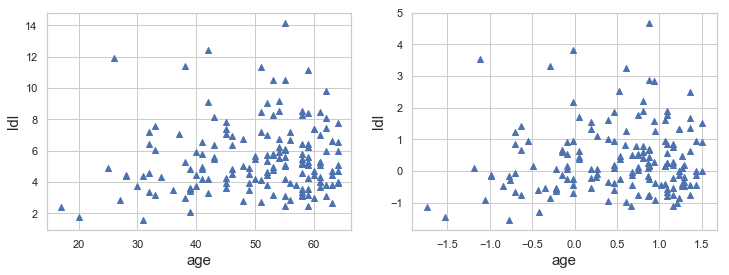

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(df[df["chd"]==1]["age"],df[df["chd"]==1]["ldl"],marker='^',label='positive')
#ax[0].scatter(df[df["chd"]==0]["age"],df[df["chd"]==0]["ldl"],marker='x',label='negative')
ax[0].set_xlabel('age', fontsize=15)
ax[0].set_ylabel('ldl', fontsize=15)
ax[1].scatter(df_norm[df_norm["chd"]==1][0],df_norm[df_norm["chd"]==1][1],marker='^',label='positive')
#ax[1].scatter(df_norm[df_norm["chd"]==0][0],df_norm[df_norm["chd"]==0][1],marker='x',label='negative')
ax[1].set_xlabel('age', fontsize=15)
ax[1].set_ylabel('ldl', fontsize=15)
#ax[1].legend()

### Step 5: Build the model framework

In [18]:
# Begin building the model framework
# Declare the variables that need to be learned and initialization
# There are 2 features here, A's dimension is (2, 1)
A = tf.Variable(tf.random_normal(shape=[2, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [19]:
# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 2])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [20]:
# Declare the model you need to learn
mod = tf.matmul(data, A) + b

In [21]:
# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

W1030 14:03:37.647011  3160 deprecation.py:323] From C:\Users\rwang\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
# Define the learning rate， batch_size etc.
learning_rate = 0.001
batch_size = 30
iter_num = 15000

In [23]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

In [24]:
# Define the goal
goal = opt.minimize(loss)

In [25]:
# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

In [26]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

### Step 6: Model training

In [27]:
# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# saver = tf.train.Saver() # defaults to saving all variables 

In [28]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X[batch_index]
    batch_train_y = np.matrix(train_y[batch_index]).T
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: np.matrix(test_y).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))
        saver.save(sess, checkpoint_dir + 'model.ckpt')


epoch:  300 loss: 1.198251 train_acc: 0.351351 test_acc: 0.304348
epoch:  600 loss: 0.892514 train_acc: 0.362162 test_acc: 0.304348
epoch:  900 loss: 0.921104 train_acc: 0.362162 test_acc: 0.315217
epoch: 1200 loss: 1.075382 train_acc: 0.375676 test_acc: 0.336957
epoch: 1500 loss: 1.062652 train_acc: 0.389189 test_acc: 0.347826
epoch: 1800 loss: 1.031662 train_acc: 0.394595 test_acc: 0.347826
epoch: 2100 loss: 0.773433 train_acc: 0.408108 test_acc: 0.358696
epoch: 2400 loss: 0.799704 train_acc: 0.432432 test_acc: 0.369565
epoch: 2700 loss: 0.802396 train_acc: 0.445946 test_acc: 0.369565
epoch: 3000 loss: 0.781173 train_acc: 0.478378 test_acc: 0.358696
epoch: 3300 loss: 0.655021 train_acc: 0.527027 test_acc: 0.434783
epoch: 3600 loss: 0.756973 train_acc: 0.637838 test_acc: 0.510870
epoch: 3900 loss: 0.680430 train_acc: 0.664865 test_acc: 0.576087
epoch: 4200 loss: 0.598445 train_acc: 0.670270 test_acc: 0.597826
epoch: 4500 loss: 0.588460 train_acc: 0.675676 test_acc: 0.597826
epoch: 480

### Step 7: Visualization

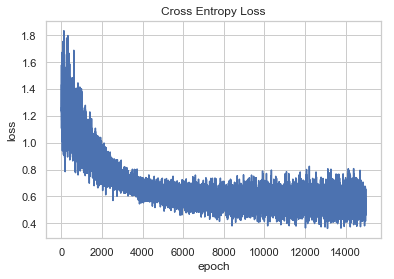

In [29]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./loss.jpg')
plt.show()

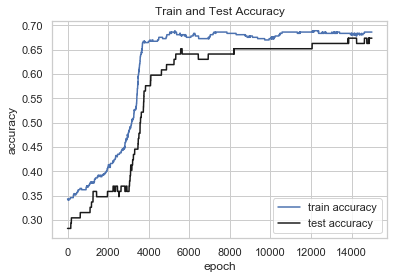

In [30]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.savefig('./accuracy.jpg')
plt.show()

### Step 8: Belief functions analysis (论文内容)

In [31]:
# 训练得到的参数
beta=sess.run(A)
beta_0=sess.run(b)
alpha=(beta_0/len(beta))[0] #论文第4章中证明，alpha_j=beta_0/J (Equ.25)
print("beta=",beta)
print("beta_0=",beta_0)
print("alpha=",alpha)

# beta= [[0.5974239]
#  [0.3825687]]
# beta_0= [[-0.7394441]]
# alpha= [-0.36972204]

beta= [[0.5974239]
 [0.3825687]]
beta_0= [[-0.7394441]]
alpha= [-0.36972204]


In [32]:
# # test code
# weights= np.empty((len(df_norm.index), len(beta)))
# print(weights.shape)
# np.array([df_norm[0]*beta[0]+alpha]).shape


(462, 2)


(1, 462)

In [33]:
# Definition of the weights of evidence w_j = beta_j*phi(x)+alpha_j, refer to Equ.16 in paper NNBelief
def trained_weight(A,b,X):  
    weights= np.empty((len(X.index), len(A)))
    for i in range(len(A)):
        weights[:,[i]]= np.array([X[i]*A[i]+b]).T
    return weights 

# Calculate positive & negative weights of evidence (w^+,w^-，参见Equ.16下面那段描述)
def weight_of_evidence(weight):
    W=[]
    if isinstance(weight[0],list):
        for i in range(len(weight)):
            W.append((max(0,weight[i][0]),max(0,-weight[i][0])))
    else:
        for i in range(len(weight)):
            W.append((max(0,weight[i]),max(0,-weight[i])))        
    return W

# Calculate the sum of positive & negative weights (参见Equ.17下面一行公式)
def sum_weight(W):
    weight_pos_temp = np.empty((W.shape[0], W.shape[1]))
    weight_neg_temp = np.empty((W.shape[0], W.shape[1]))
    weight_pos = np.empty((W.shape[0], 1))
    weight_neg = np.empty((W.shape[0], 1))
    for i in range(W.shape[1]):
        weight_pos_temp[:,[i]]=np.array(weight_of_evidence(W[:,[i]]))[:,[0]]
        weight_neg_temp[:,[i]]=np.array(weight_of_evidence(W[:,[i]]))[:,[1]]
    weight_pos=np.sum(weight_pos_temp,axis=1)
    weight_neg=np.sum(weight_neg_temp,axis=1)
    return(weight_pos,weight_neg)

# Definition of the degree of conflict k=[1-exp(-w^+)]*[1-exp(-w^-)] (Equ.21c)
def degree_of_conflict(W_pos,W_neg):
    k=(1-np.exp(-1*W_pos))*(1-np.exp(-1*W_neg))
    return k

# Calculate conflict from trained parameters and feature values
def conflict(A,b,X):
    w_j=trained_weight(A,b,X)   
    weight_pos,weight_neg=sum_weight(w_j)
    k=degree_of_conflict(weight_pos,weight_neg)
    return k

In [34]:
# # test code
# X=[-1,2,-3,4,-5,-6]
# print(weight_of_evidence(X))
# Y=[[-1],[2],[-3],[4],[-5],[-6]]
# print(weight_of_evidence(Y))   
# Z=np.array([1,2,3,4,5,6])
# print(np.exp(Z))

[(0, 1), (2, 0), (0, 3), (4, 0), (0, 5), (0, 6)]
[(0, 1), (2, 0), (0, 3), (4, 0), (0, 5), (0, 6)]
[  2.71828183   7.3890561   20.08553692  54.59815003 148.4131591
 403.42879349]


In [35]:
# Weights of evidence 
weights=trained_weight(beta,alpha,df_norm)
#print(weights[:,[0]])
#print(np.array(weight_of_evidence(weights[:,[0]])))
print(weights)

[[-1.03905243e+00 -7.53017789e-01]
 [-8.32778693e-01 -4.30790844e-01]
 [-7.68376295e-03 -7.41711581e-01]
 [-8.74033440e-01 -5.51390402e-01]
 [-9.97797679e-01 -6.56915016e-01]
 [ 3.63608956e-01  2.77731563e-01]
 [-4.20231228e-01 -1.61326205e-01]
 [ 4.04863702e-01 -5.41968562e-01]
 [-1.45159989e+00 -5.21240513e-01]
 [ 5.28627942e-01 -3.30919334e-01]
 [-1.03905243e+00 -5.04281200e-01]
 [ 3.35709836e-02 -5.79655924e-01]
 [-1.32783565e+00 -6.92718010e-01]
 [-7.68376295e-03 -1.85822990e-01]
 [-3.78976482e-01 -6.34302599e-01]
 [-7.91523947e-01  9.87165933e-02]
 [ 5.28627942e-01  5.34917588e-02]
 [-7.68376295e-03 -4.55287629e-01]
 [-1.08030717e+00 -4.27022108e-01]
 [ 4.87373195e-01 -4.82641188e-02]
 [-1.08030717e+00 -3.32803702e-01]
 [-1.24532616e+00 -7.20983532e-01]
 [-4.20231228e-01 -1.29291947e-01]
 [-1.12156192e+00 -4.64709470e-01]
 [-2.13957496e-01 -1.95244831e-01]
 [ 1.98589970e-01  1.06254066e-01]
 [ 7.48257301e-02 -6.66336857e-01]
 [-1.28658091e+00 -5.60812243e-01]
 [-9.01932560e-02 -1

In [36]:
# # test code
# np.array(weight_of_evidence(weights[:,[0]]))[:,[1]]+np.array(weight_of_evidence(weights[:,[1]]))[:,[1]]

array([[array([1.79207022])],
       [array([1.26356954])],
       [array([0.74939534])],
       [array([1.42542384])],
       [array([1.6547127])],
       [0],
       [array([0.58155743])],
       [array([0.54196856])],
       [array([1.9728404])],
       [array([0.33091933])],
       [array([1.54333363])],
       [array([0.57965592])],
       [array([2.02055366])],
       [array([0.19350675])],
       [array([1.01327908])],
       [array([0.79152395])],
       [0],
       [array([0.46297139])],
       [array([1.50732928])],
       [array([0.04826412])],
       [array([1.41311087])],
       [array([1.96630969])],
       [array([0.54952318])],
       [array([1.58627139])],
       [array([0.40920233])],
       [0],
       [array([0.66633686])],
       [array([1.84739315])],
       [array([0.19875715])],
       [array([1.83608694])],
       [array([1.64737657])],
       [array([0.33772174])],
       [array([0.85795549])],
       [array([0.54008419])],
       [array([0.79070515])],
      

In [37]:
# positive and negative weights
weight_pos,weight_neg=sum_weight(weights)
# degree of conflict
k=degree_of_conflict(weight_pos,weight_neg)

In [39]:
#用conflict()直接求k值
kk=conflict(beta,alpha,df_norm)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.139, 0.   ,
       0.116, 0.   , 0.015, 0.   , 0.   , 0.   , 0.051, 0.   , 0.   ,
       0.   , 0.018, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.035,
       0.   , 0.   , 0.   , 0.   , 0.073, 0.   , 0.15 , 0.151, 0.   ,
       0.01 , 0.087, 0.   , 0.111, 0.   , 0.   , 0.015, 0.   , 0.001,
       0.128, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.248, 0.046,
       0.   , 0.   , 0.   , 0.   , 0.117, 0.   , 0.   , 0.   , 0.   ,
       0.028, 0.   , 0.   , 0.09 , 0.   , 0.   , 0.   , 0.002, 0.083,
       0.011, 0.014, 0.   , 0.021, 0.   , 0.   , 0.   , 0.004, 0.   ,
       0.405, 0.   , 0.   , 0.   , 0.175, 0.   , 0.011, 0.095, 0.045,
       0.065, 0.113, 0.195, 0.   , 0.   , 0.071, 0.   , 0.   , 0.   ,
       0.165, 0.   , 0.044, 0.   , 0.004, 0.   , 0.005, 0.   , 0.   ,
       0.   , 0.104, 0.   , 0.   , 0.   , 0.015, 0.012, 0.   , 0.   ,
       0.035, 0.   , 0.   , 0.171, 0.092, 0.027, 0.057, 0.   , 0.168,
       0.06 , 0.   ,

Text(0.5, 1.0, 'degree of conflict')

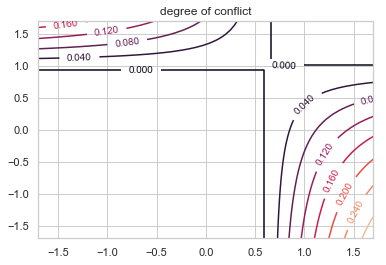

In [217]:
#画图8(c)实线部分，k值的轮廓线

ldl = np.arange(0,15,0.3)
age = np.arange(0,70,1.4)

ldl_norm=mean_std_normalized(ldl)
age_norm=mean_std_normalized(age)

#将原始数据变成网格数据形式
X,Y = np.meshgrid(age_norm,ldl_norm)
kk=conflict(beta,alpha,pd.DataFrame({0:(X.flatten()),1:(Y.flatten())})).reshape(50,50)

fig, ax = plt.subplots()
CS = ax.contour(X, Y, kk)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('degree of conflict')
